In [1]:
import h5py
import numpy as np; import pandas as pd
from sklearn import linear_model, neighbors
import sklearn.neighbors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing, linear_model, metrics 
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_auc_score, roc_curve, auc
def plot_roc(Y_test, Y_test_score, TPR, TNR):
    %matplotlib notebook
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'Arial'
    matplotlib.rcParams['font.size'] = '20.0'
    matplotlib.rcParams['text.usetex'] = False

    fig, ax  = plt.subplots(figsize=(10,7))
    fig.patch.set_facecolor('white')

    fpr, tpr, thrs = roc_curve(Y_test, Y_test_score[:,1])
    roc_auc = auc(fpr, tpr)
    l2=ax.plot(fpr, tpr, color='darkblue',lw=5, label='AUC = %0.2f' % roc_auc, zorder=5)
    sc=ax.scatter(1-TNR, TPR, marker='x',c='r', s=80, zorder=6)

    ax.set_aspect('equal')
    #ax.set_title('ROC curve, KNN , bin porosity=0.05%', Fontsize=22)
    ax.minorticks_on()
    ax.grid(which='both')
    ax.set_xlabel('PFA', Fontsize=22)
    ax.set_ylabel('POD', Fontsize=22)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right')
    plt.xticks(fontsize=20) 
    plt.xticks(fontsize=20)
    print(thrs)

In [3]:
import math
def equi_pore(perct, voxelsize, unit):
    if unit == 'mm':
        voxelsize=voxelsize*1000
        
    V_voxel=voxelsize*voxelsize*voxelsize
    V_pore=V_voxel*(perct/100)
    r_pore=((3*V_pore)/(4*math.pi))**(1./3)
    d_pore=2*r_pore
    
    return d_pore

In [4]:
def performance_info(truth, prediction, probability):
    auc=metrics.roc_auc_score(truth, probability)
    tn, fp, fn, tp = metrics.confusion_matrix(truth, prediction).ravel()
    tpr_model=tp/(tp+fn)
    tnr_model=tn/(tn+fp)
    print('POD = '+str(tpr_model))
    print('PFA = '+str(1-(tnr_model)))
    print('AUC = ', auc)
    print('... with {0} true negatives, {1} true positives, {2} false negatives and {3} false positives'.format(tn,tp,fn,fp))
    
    return tpr_model, tnr_model

## Lumping all data together for test and train

In [5]:
def unpack_reg(reg_data_file):
    raw_data={}
    with h5py.File(reg_data_file, 'r') as f:
        for key in f.keys():
            raw_data[key]=np.array(f[key])
    keys_all=raw_data.keys()
    print(keys_all)
    return raw_data, keys_all

In [6]:
# load and unpack the raw data
part1="Hori_Bar_registered.h5"
part2="Chamfer_registered_data.h5"
part3="F:\\pd\\ML_models\\LEGO1\\2mm\\registered_data.h5"
part4=""
raw1, keys_all = unpack_reg(part1)
raw2, _ = unpack_reg(part2)
#raw3, _ = unpack_reg(part3)

dict_keys(['mask', 'max-Plume area (um2)', 'max-Plume major axis (um)', 'max-Plume mean intensity', 'max-Plume min intensity', 'max-Plume minor axis (um)', 'max-Spatter mean area', 'max-Spatter mean mean intensity', 'max-Spatter number', 'max-Spatter total area', 'max-Spot area (um2)', 'max-Spot major axis (um)', 'max-Spot mean intensity', 'max-Spot minor axis (um)', 'max-X', 'max-Y', 'max-Z', 'mean-Plume area (um2)', 'mean-Plume major axis (um)', 'mean-Plume mean intensity', 'mean-Plume min intensity', 'mean-Plume minor axis (um)', 'mean-Spatter mean area', 'mean-Spatter mean mean intensity', 'mean-Spatter number', 'mean-Spatter total area', 'mean-Spot area (um2)', 'mean-Spot major axis (um)', 'mean-Spot mean intensity', 'mean-Spot minor axis (um)', 'mean-X', 'mean-Y', 'mean-Z', 'mse-Plume area (um2)', 'mse-Plume major axis (um)', 'mse-Plume mean intensity', 'mse-Plume min intensity', 'mse-Plume minor axis (um)', 'mse-Spatter mean area', 'mse-Spatter mean mean intensity', 'mse-Spatter

In [8]:
def unwrap_to_PC(raw_data):
    df=pd.DataFrame(columns=[*keys_all, 'x','y','z'])

    i=0
    for z in range(raw_data['mask'].shape[0]):
        for y in range(raw_data['mask'].shape[2]):
            for x in range(raw_data['mask'].shape[1]):

                if raw_data['mask'][z,x,y] == 1 and raw_data['mean-Spot mean intensity'][z,x,y]>10:    #some pore thresh val can be added

                    df.loc[i,'x']=x; df.loc[i,'y']=y; df.loc[i,'z']=z; 

                    for key in keys_all:
                        df.loc[i, key]=raw_data[key][z,x,y]

                    i=i+1
    return df

In [9]:
df1=unwrap_to_PC(raw1)
df2=unwrap_to_PC(raw2)
#df3=unwrap_to_PC(raw3)

In [10]:
df1=df1[~df1.isin([np.nan, np.inf, -np.inf]).any(1)]
df2=df2[~df2.isin([np.nan, np.inf, -np.inf]).any(1)]
#df3=df3[~df3.isin([np.nan, np.inf, -np.inf]).any(1)]
print(np.sum(df1.isin([np.inf])))
#print(np.sum(df2.isin([np.inf])))
#print(np.sum(df3.isin([np.inf])))

mask                         0
max-Plume area (um2)         0
max-Plume major axis (um)    0
max-Plume mean intensity     0
max-Plume min intensity      0
                            ..
raw-Y                        0
raw-Z                        0
x                            0
y                            0
z                            0
Length: 69, dtype: int64


In [17]:
# extract the features 
#not_these=['x', 'y', 'z', 'mask', 'pores']
#these=[i for i in df1.columns if i not in not_these]
features=df1.columns[1:-4]

SyntaxError: invalid syntax (<ipython-input-17-f68b4424298f>, line 3)

In [18]:
#construct master df
#df=df1
df=df1.append(df2, ignore_index=True)
#df=df.append(df3, ignore_index=True)
#df_val=df2.append(df3,ignore_index=True)

In [19]:
len(df), len(df1), len(df2)


(4891, 2301, 2590)

In [20]:
%matplotlib widget
plt.plot(df1.pores)
plt.plot(df2.pores)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### with KNN, no bias correction

In [119]:
standard_scaler = preprocessing.MinMaxScaler()  
standard_scaler.fit(df[features])
x = standard_scaler.transform(df[features])
pore_thres = 0.4  # our pore threshold here
Y = df.pores > pore_thres 

shuffles=[0,1]
base_fpr = np.linspace(0, 1, 101)
tprs=[]
for n in shuffles:
    #no resampling here
    x_train, x_test, pores_train, pores_test = train_test_split(x, df.pores, test_size=.2, random_state=n)

    Y_train=pores_train>pore_thres
    Y_test=pores_test>pore_thres
    #initialise model
    model_parameters = [{'n_neighbors': [5, 10, 15, 20, 50], 'weights': ['uniform', 'distance'], 'p':[1,2,3]}]
    knn = sklearn.neighbors.KNeighborsClassifier()
    clf = sklearn.model_selection.GridSearchCV(knn,model_parameters,scoring= 'roc_auc', cv=20)  

    clf.fit(x_train, Y_train)

    Y_test_score =  clf.predict_proba(x_test)
    Y_train_score =  clf.predict_proba(x_train) # should give perfect prediction
    Y_train_pred=clf.predict(x_train)
    Y_test_pred=np.where(Y_test_score[:,1] > 0.5, 1, 0)
    #Y_test_pred=clf.predict(x_test)

    # print performance information
    TPR, TNR=performance_info(Y_test, Y_test_pred, Y_test_score[:,1])
    fpr_vec, tpr_vec,thrs = roc_curve(Y_test, Y_test_score[:,1])
    tpr = np.interp(base_fpr, fpr_vec, tpr_vec)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std   
#plt.plot(base_fpr, mean_tprs, 'b')

POD = 0.6781609195402298
PFA = 0.0033632286995515237
AUC =  0.9906061543219421
... with 889 true negatives, 59 true positives, 28 false negatives and 3 false positives
POD = 0.723404255319149
PFA = 0.002259887005649719
AUC =  0.9802981127539366
... with 883 true negatives, 68 true positives, 26 false negatives and 2 false positives


<IPython.core.display.Javascript object>


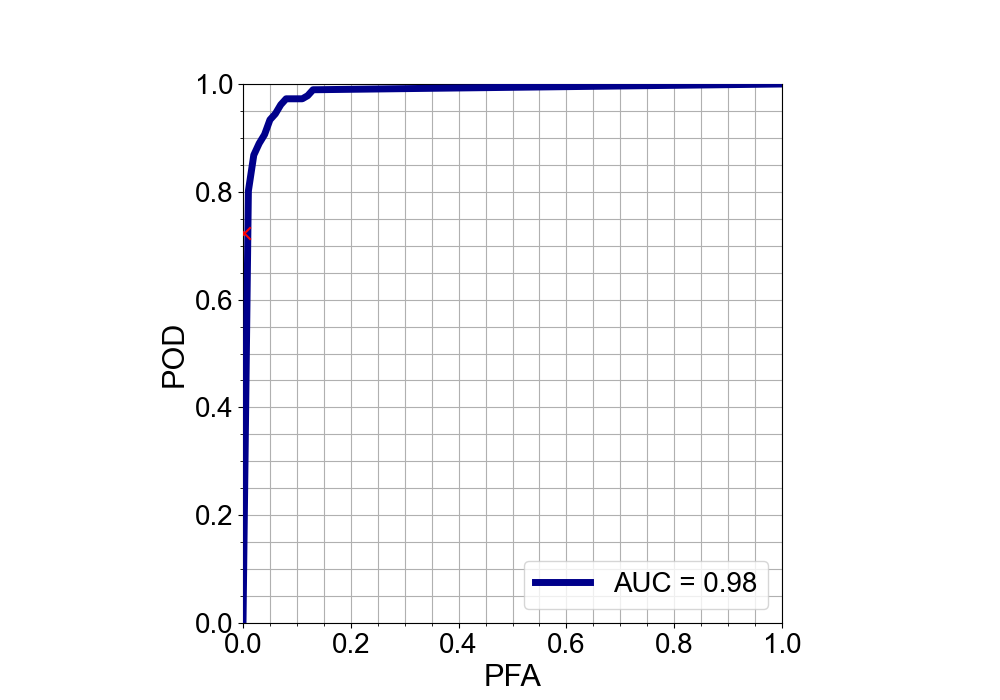

C:\Users\rw1816\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app
C:\Users\rw1816\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [120]:
%matplotlib notebook
#plt.plot(base_fpr, mean_tprs)

fig, ax  = plt.subplots(figsize=(10,7))
fig.patch.set_facecolor('white')

roc_auc = auc(base_fpr, mean_tprs)
l2=ax.plot(base_fpr, mean_tprs, color='darkblue',lw=5, label='AUC = %0.2f' % roc_auc, zorder=5)
sc=ax.scatter(1-TNR, TPR, marker='x',c='r', s=80, zorder=6)

ax.set_aspect('equal')
#ax.set_title('ROC curve, KNN , bin porosity=0.05%', Fontsize=22)
ax.minorticks_on()
ax.grid(which='both')
ax.set_xlabel('PFA', Fontsize=22)
ax.set_ylabel('POD', Fontsize=22)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')
plt.xticks(fontsize=20) 
plt.xticks(fontsize=20)
#print(thrs)

In [145]:
harry=pd.DataFrame({"fprs":base_fpr, "tprs":mean_tprs})

In [149]:
harry.to_csv("F://downloads//ATLAS_IDv3_barY+chamfer_KNN_1mm_0p4.csv")

<IPython.core.display.Javascript object>


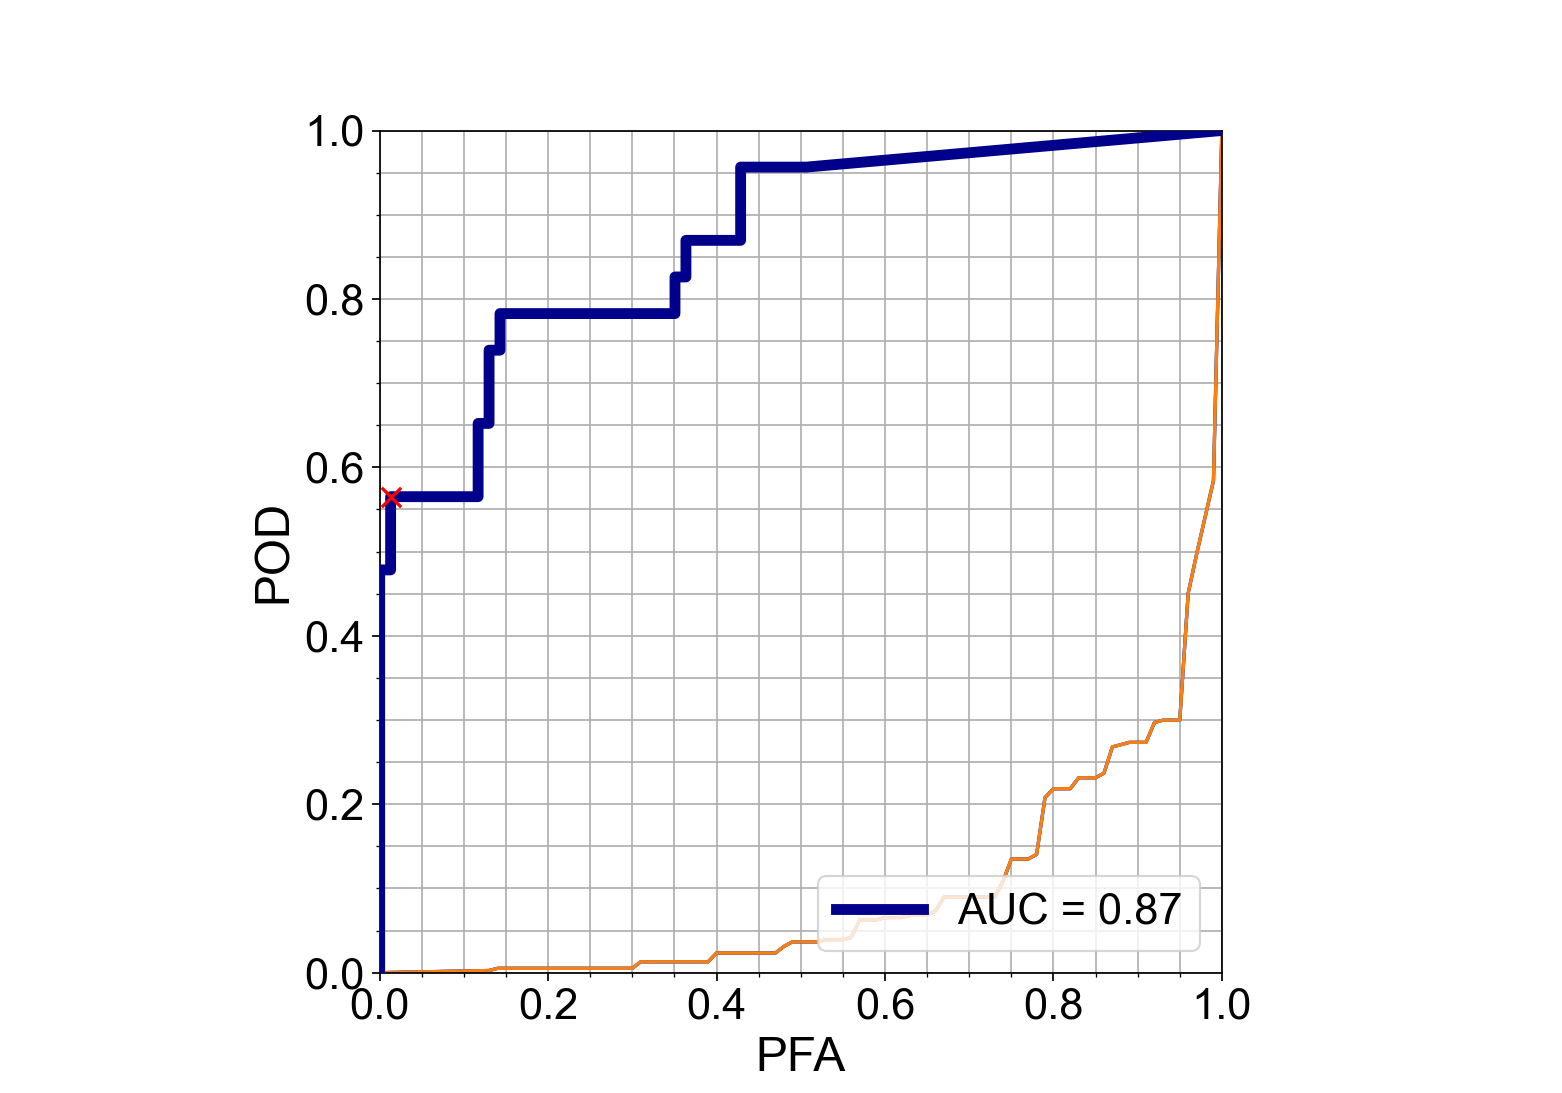

[2.         1.         0.62328494 0.57718508 0.51731986 0.32681534
 0.27713481 0.27115918 0.2214152  0.21367154 0.20488271 0.1245026
 0.12197307 0.12174136 0.12101949 0.06999299 0.06777231 0.05474256
 0.        ]


In [65]:
plot_roc(Y_test, Y_test_score, TPR, TNR)

In [586]:
scores = cross_val_score(clf, x_test, Y_test, cv=5, scoring='roc_auc')  

In [587]:
print(scores)

[0.95138889 0.90972222 0.79166667 0.98611111 0.76      ]


### with Random Forest

In [138]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

standard_scaler = preprocessing.MinMaxScaler()  #initialiser a scaler object
x = standard_scaler.fit_transform(df[features])
pore_thres = 0.1  #threshold it against a value of 0.08%
Y = df.pores > pore_thres #above 0.08% = porous/bad, below 0.08% = OK

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=.2,random_state=0)
# pull out a randomised 80:20 split to train and test

# Train model
rfc = RandomForestClassifier()
params={'bootstrap': [True, False],
 'max_depth': [10, 20, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 400, 600]}

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = params, n_iter = 80, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1, scoring="roc_auc")
rfc_random.fit(x_train, Y_train)

Y_test_score =  rfc_random.predict_proba(x_test)
Y_train_score =  rfc_random.predict_proba(x_train) # should give perfect prediction
Y_train_pred=rfc_random.predict(x_train)
Y_test_pred=np.where(Y_test_score[:,1] > 0.5, 1, 0)
#Y_test_pred=clf.predict(x_test)

# print performance information
TPR,TNR=performance_info(Y_test, Y_test_pred, Y_test_score[:,1])

Fitting 3 folds for each of 80 candidates, totalling 240 fits
POD = 0.9979716024340771
PFA = 0.0
AUC =  0.9999749580547417
... with 486 true negatives, 492 true positives, 1 false negatives and 0 false positives
Wall time: 2min 6s


<IPython.core.display.Javascript object>


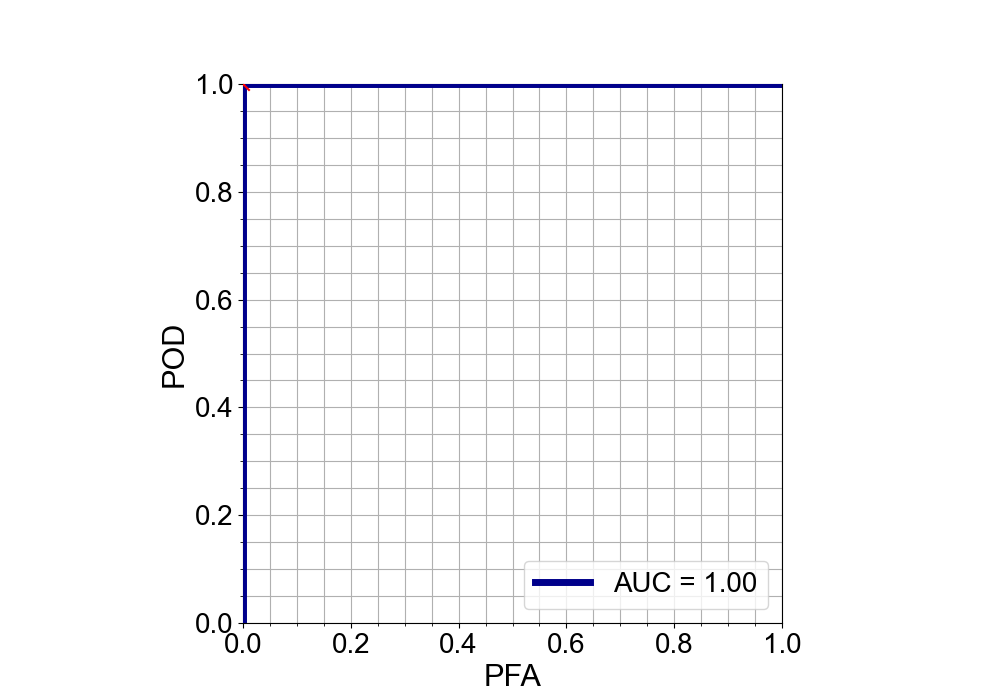

[1.98805556e+00 9.88055556e-01 5.38055556e-01 8.19444444e-02
 8.11111111e-02 6.36111111e-02 6.33333333e-02 5.63888889e-02
 5.61111111e-02 4.94444444e-02 4.91666667e-02 4.13888889e-02
 4.08333333e-02 4.02777778e-02 3.94444444e-02 3.79166667e-02
 3.77777778e-02 3.02777778e-02 2.97222222e-02 2.72222222e-02
 2.66666667e-02 2.61111111e-02 2.61111111e-02 2.52777778e-02
 2.52777778e-02 2.27777778e-02 2.13888889e-02 2.11111111e-02
 2.08333333e-02 1.86111111e-02 1.83333333e-02 1.77777778e-02
 1.75000000e-02 1.61111111e-02 1.61111111e-02 1.58333333e-02
 1.52777778e-02 1.36111111e-02 1.30555556e-02 1.25000000e-02
 1.25000000e-02 1.19444444e-02 1.19444444e-02 1.16666667e-02
 1.13888889e-02 1.11111111e-02 1.11111111e-02 1.08333333e-02
 1.08333333e-02 1.05555556e-02 1.02777778e-02 9.44444444e-03
 9.44444444e-03 9.16666667e-03 9.16666667e-03 8.88888889e-03
 8.88888889e-03 8.88888889e-03 8.33333333e-03 8.33333333e-03
 8.05555556e-03 7.77777778e-03 7.77777778e-03 7.50000000e-03
 7.22222222e-03 6.944444

C:\Users\rw1816\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\rw1816\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [132]:
plot_roc(Y_test, Y_test_score, TPR, TNR)

<IPython.core.display.Javascript object>


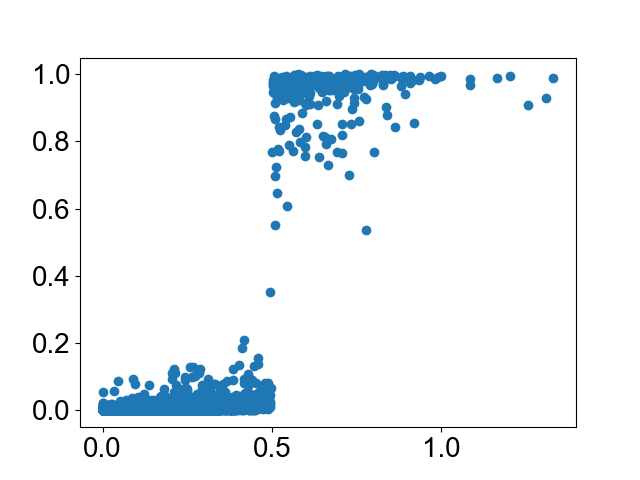

In [137]:
%matplotlib widget
plt.scatter(df.pores, rfc_random.predict_proba(x)[:,1])

<IPython.core.display.Javascript object>


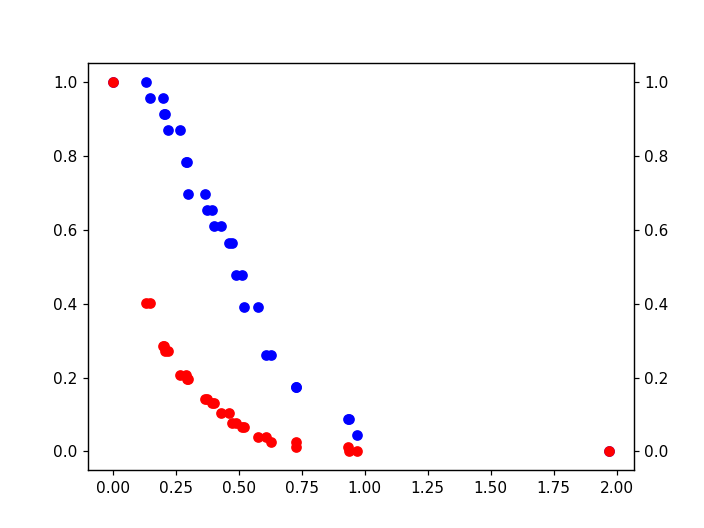

In [44]:
%matplotlib notebook
fpr, tpr, thrs = roc_curve(Y_test, Y_test_score[:,1])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(thrs, tpr, c='b')
ax2.scatter(thrs, fpr, c='r')

## Training on part 1, testing on part 2 + 3

### with KNN

In [128]:
scaler = preprocessing.StandardScaler()
scaler.fit(df1[features])
x_train = scaler.transform(df1[features])
scal_params=scaler.get_params()

pore_thres = 0.5  # our pore threshold here
Y_train = df1.pores > pore_thres 

#initialise model
model_parameters = [{'n_neighbors': [5, 10, 15, 20, 50], 'weights': ['uniform', 'distance'], 'p':[1,2,3]}]
knn = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.model_selection.GridSearchCV(knn, model_parameters, scoring= 'roc_auc', cv=20)  
clf.fit(x_train, Y_train)

# validate on part 2, unseen data
x_val = scaler.transform(df2[features])
#x_val=np.vstack((x_val,standard_scaler.fit_transform(df3[features])))
Y_val_score = clf.predict_proba(x_val)
#Y_val_pred=np.where(Y_val_score[:,1] > .5, 1, 0)
Y_val_pred=clf.predict(x_val)
Y_true = df2.pores > pore_thres
#Y_test_pred=clf.predict(x_test)

# print performance information
TPR,TNR=performance_info(Y_true, Y_val_pred, Y_val_score[:,1])

POD = 0.0
PFA = 0.0
AUC =  0.481361347792409
... with 2582 true negatives, 0 true positives, 8 false negatives and 0 false positives


<IPython.core.display.Javascript object>


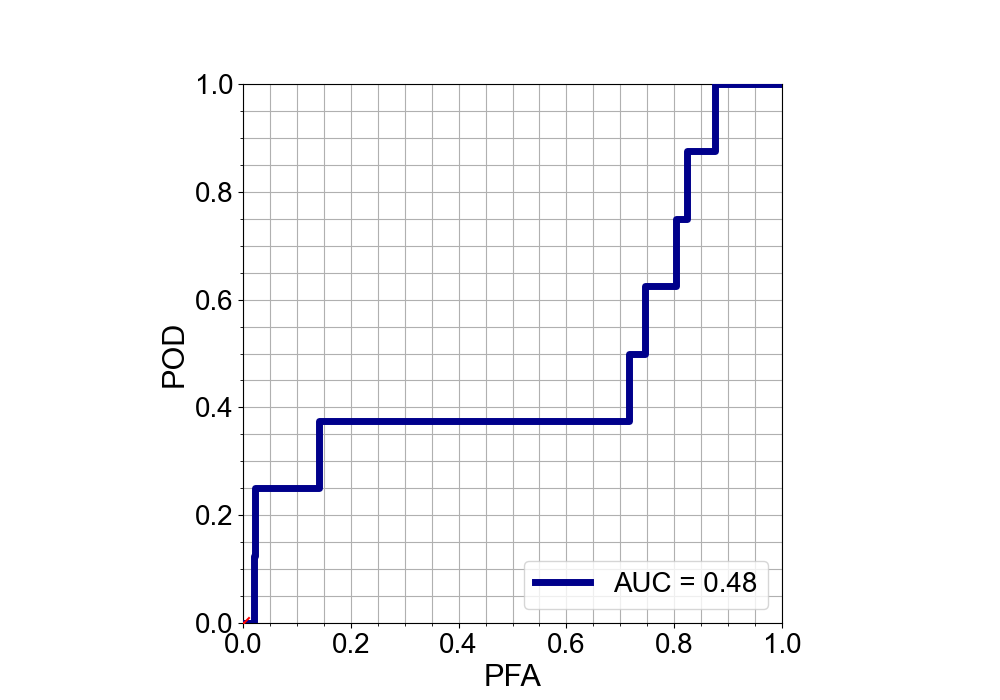

[1.4797301  0.4797301  0.39327892 0.38115006 0.38014075 0.38002833
 0.26089182 0.26049406 0.0599712  0.05995808 0.0573942  0.05738723
 0.03859378 0.03851294 0.01996426 0.01996191 0.0191557  0.01914513
 0.01823567 0.        ]


C:\Users\rw1816\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\rw1816\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [129]:
plot_roc(Y_true, Y_val_score, TPR, TNR)

In [487]:
scaler = preprocessing.StandardScaler()
scaler.fit(df1[features])
x_train = scaler.transform(df1[features])
scal_params=scaler.get_params()

pore_thres = 0.05  # our pore threshold here
Y_train = df1.pores > pore_thres 

#initialise model
#model_parameters = [{'n_neighbors': [3, 5, 10, 15, 20, 50], 'weights': ['uniform', 'distance'], 'p':[1,2,3,5,10]}]
#knn = sklearn.neighbors.KNeighborsClassifier()
#clf = sklearn.model_selection.GridSearchCV(knn,model_parameters,scoring= 'roc_auc', cv=20)
clf=RandomForestClassifier()
clf.fit(x_train, Y_train)

# validate on part 2, unseen data
x_val = scaler.fit_transform(df_val[features])
#x_val=np.vstack((x_val,standard_scaler.fit_transform(df3[features])))
Y_val_score = clf.predict_proba(x_val)
#Y_val_pred=np.where(Y_val_score[:,1] > .5, 1, 0)
Y_val_pred=clf.predict(x_val)
Y_true = df_val.pores > pore_thres
#Y_test_pred=clf.predict(x_test)

# print performance information
TPR,TNR=performance_info(Y_true, Y_val_pred, Y_val_score[:,1])

POD = 0.06796116504854369
PFA = 0.23239436619718312
AUC =  0.20518255162040205
... with 109 true negatives, 7 true positives, 96 false negatives and 33 false positives


### KNN with bias correction

In [71]:
standard_scaler = preprocessing.MinMaxScaler()  
x_train = standard_scaler.fit_transform(df1[features])

pore_thres = 0.05  # our pore threshold here
Y_train = df1.pores > pore_thres
Trues=Y_train==1; Falses=Y_train==0
Y_train = np.hstack((Y_train[Trues], Y_train[Falses][0:-1:int(len(Y_train)/len(Trues))]))
x_train = np.vstack((x_train[Trues], x_train[Falses][0:-1:int(len(x_train)/len(Trues))]))

#initialise model
model_parameters = [{'n_neighbors': [3, 5, 10, 15, 20, 50], 'weights': ['uniform', 'distance'], 'p':[1,2]}]
knn = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.model_selection.GridSearchCV(knn,model_parameters,scoring= 'roc_auc', cv=10)  
clf.fit(x_train, Y_train)

# validate on part 2, unseen data
x_val = standard_scaler.fit_transform(df_val[features])
Y_val_score =  clf.predict_proba(x_val)
Y_val_pred=np.where(Y_val_score[:,1] > 0.59863096, 1, 0)
Y_true = df2.pores > 0.05
#Y_test_pred=clf.predict(x_test)

# now calculate the precision and recall based on our predictions
precision=metrics.precision_score(Y_true, Y_val_pred)
recall=metrics.recall_score(Y_true, Y_val_pred)
report=metrics.classification_report(Y_true, Y_val_pred)

# print performance information
performance_info(Y_true, Y_val_pred, Y_val_score[:,1])

POD = 1.0
PFA = 0.18487394957983194
AUC =  0.9411764705882353
... with 97 true negatives, 1 true positives, 0 false negatives and 22 false positives


## K folds cross

<IPython.core.display.Javascript object>


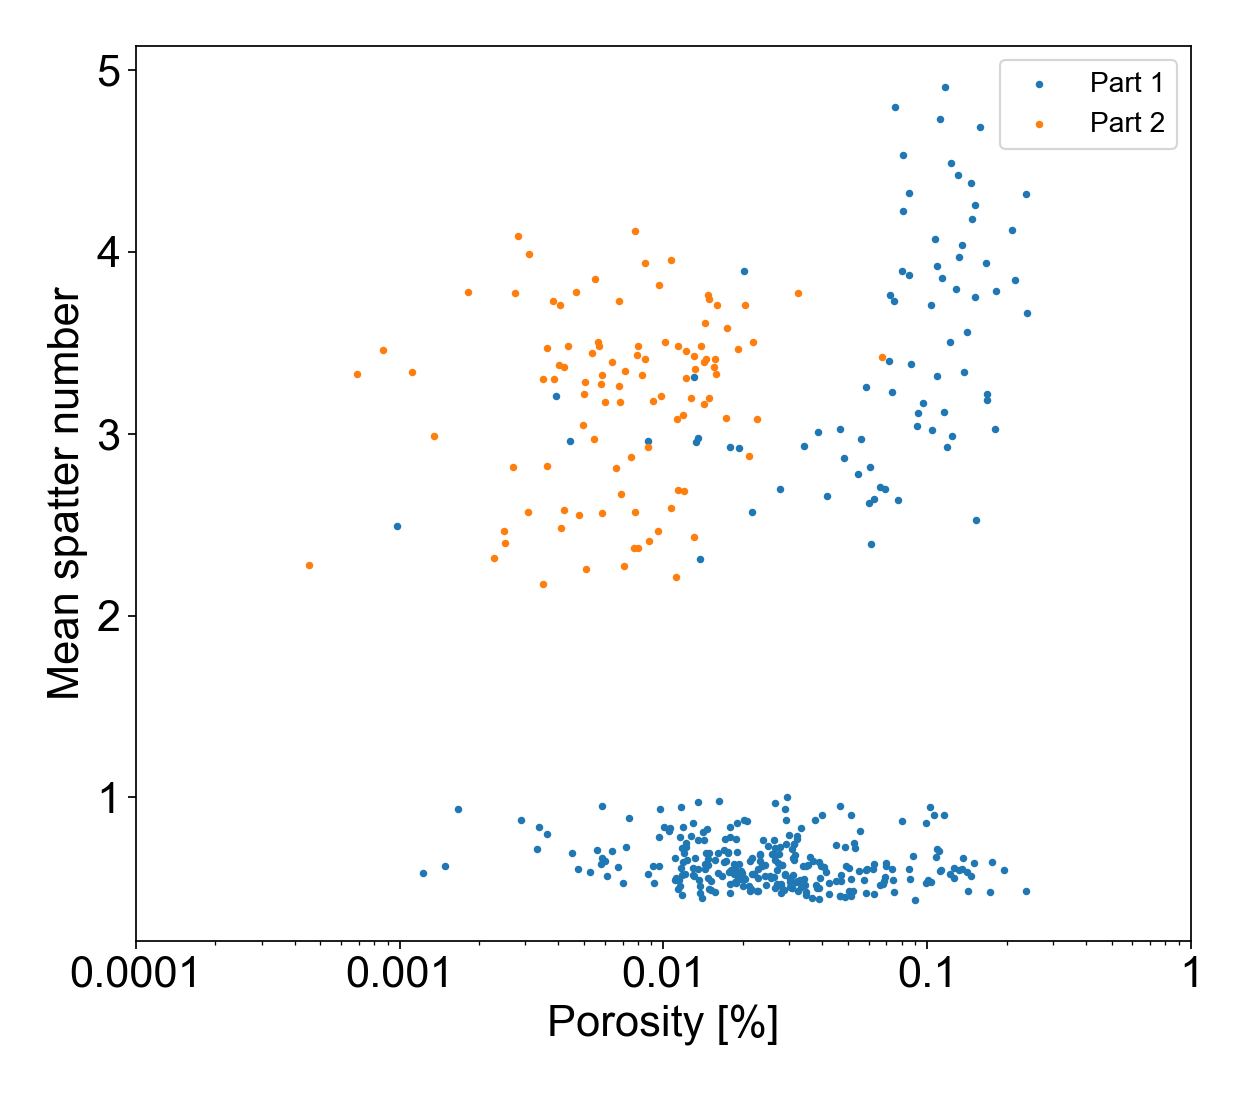

In [21]:
fig, ax= plt.subplots(figsize=(8,7))
for d in [df1, df2]:
    ax.scatter(d['pores'], d['mean-Spatter number'], s=6)
ax.legend(('Part 1', 'Part 2'), prop={'size': 13})

ax.set_xlabel(r'Porosity [%]')
ax.set_ylabel(r'Mean spatter number')
ax.set_xscale('log')
ax.set_xlim([0.0001, 1])
ax.set_xticklabels([0.000001, 0.0001, 0.001, 0.01, 0.1, 1])
plt.tight_layout()